In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [390]:
data = pd.read_csv(r"C:\Users\minek\Desktop\User Journey Analysis in Python Project\user_journey_raw.csv")

In [391]:
data.head()

,user_id,session_id,subscription_type,user_journey
0,1516,2980231,Annual,Homepage-Log in-Log in-Log in-Log in-Log in-Lo...
1,1516,2980248,Annual,Other-Sign up-Sign up-Sign up-Sign up-Sign up-...
2,1516,2992252,Annual,Log in-Log in-Log in-Log in-Log in-Log in
3,1516,3070491,Annual,Homepage-Log in-Log in-Log in-Log in-Log in-Lo...
4,1516,3709807,Annual,Log in-Log in-Log in-Log in-Log in-Log in-Log ...


In [392]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9935 entries, 0 to 9934
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            9935 non-null   int64 
 1   session_id         9935 non-null   int64 
 2   subscription_type  9935 non-null   object
 3   user_journey       9935 non-null   object
dtypes: int64(2), object(2)
memory usage: 310.6+ KB


## Preprocessing the Data

* Data does not include any null values.

In [393]:
data.isna().sum()

user_id              0
session_id           0
subscription_type    0
user_journey         0
dtype: int64

* I write a function for removing sequences of repeating pages. While (Homepage-Pricing-Homepage) is okay, (Homepage-Homepage-Homepage-Pricing) shoud be replaced with (Homepage-Pricing).

In [394]:
def remove_page_duplicates(data, target_column="user_journey"):
    """
    Returns a new DataFrame where the provided list of repeating pages is to be removed from the user journey strings.
    
        Parameters:
            data (pandas.DataFrame): The DataFrame containing the user journeys data
            
            target_column (str): The column containing the user journey strings
                Default: 'user_journey', the expected name of the column
        
        Returns:
            cleaned_data (pandas.DataFrame): A new DataFrame containing the data. The original DataFrame is not modified.
    """
        
    # Function to remove sequential duplicates in a string
    def clean_journey(journey):
        pages = journey.split('-')
        cleaned_pages = [pages[0]]
        for i in range(1, len(pages)):
            if pages[i] != pages[i-1]:  # Only add page if it's different from the previous one
                cleaned_pages.append(pages[i])
        return '-'.join(cleaned_pages)
    
    # Apply the clean_journey function to the target column and create a new DataFrame
    cleaned_data = data.copy()
    cleaned_data[target_column] = cleaned_data[target_column].apply(clean_journey)
    
    return cleaned_data

In [395]:
cleaned_df = remove_page_duplicates(data)
cleaned_df.head()

,user_id,session_id,subscription_type,user_journey
0,1516,2980231,Annual,Homepage-Log in-Other
1,1516,2980248,Annual,Other-Sign up-Log in
2,1516,2992252,Annual,Log in
3,1516,3070491,Annual,Homepage-Log in
4,1516,3709807,Annual,Log in


In [396]:
def group_by(data, group_column='user_id', target_column='user_journey', sessions='All', count_from='last'):
    """
    Groups and concatenates user journey strings based on specified sessions and grouping criteria.

    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the data to be grouped.
    group_column : str, optional
        The name of the column to group by (default is 'user_id').
    target_column : str, optional
        The name of the column containing the journey strings to concatenate (default is 'user_journey').
    sessions : int or str, optional
        The number of sessions to group. If 'All', considers all sessions. If an integer is provided,
        groups the specified number of sessions (default is 'All').
    count_from : str, optional
        Either 'first' or 'last'. Determines the order of session selection if `sessions` is an integer.
        'first' selects sessions from the beginning, and 'last' selects from the end (default is 'last').

    Returns:
    -------
    pd.DataFrame
        A new dataframe with the grouped and concatenated journey strings. Each row represents the combined 
        journey strings for each unique value in `group_column`.

    Raises:
    ------
    ValueError
        If `count_from` is not 'first' or 'last'.
    """


    def group_sessions(grouped_data, sessions, count_from):
        if sessions == 'All':
            selected_sessions = grouped_data
        else:
            if count_from == 'first':
                selected_sessions = grouped_data.head(sessions)
            elif count_from == 'last':
                selected_sessions = grouped_data.tail(sessions)
            else:
                raise ValueError("count_from should be either 'first' or 'last'")
        
        # Combine the selected user_journey strings into one big string
        combined_journey = '-'.join(selected_sessions[target_column].tolist())
        return combined_journey
    
    # Apply grouping based on the group_column
    grouped = data.groupby(group_column).apply(lambda x: group_sessions(x, sessions, count_from)).reset_index()

    # Rename columns to make the output clearer
    grouped.columns = [group_column, target_column]
    
    return grouped

In [397]:
# Example: Group all sessions for each user
grouped_df = group_by(cleaned_df)
grouped_df

,user_id,user_journey
0,1516,Homepage-Log in-Other-Other-Sign up-Log in-Log...
1,3395,Other-Pricing-Sign up-Log in-Homepage-Pricing-...
2,10107,Homepage-Homepage-Career tracks-Homepage-Caree...
3,11145,Homepage-Log in-Homepage-Log in-Homepage-Log i...
4,12400,Homepage-Career tracks-Sign up-Log in-Other-Ca...
...,...,...
1345,509060,Other-Other
1346,509061,Coupon
1347,509085,Coupon
1348,509095,Other-Other-Other-Other


In [443]:
# Example: Group only the first 3 sessions for each user
grouped_df_first3 = group_by(data, sessions=3, count_from='first')
grouped_df_first3

,user_id,user_journey
0,1516,Homepage-Log in-Log in-Log in-Log in-Log in-Lo...
1,3395,Other-Other-Pricing-Sign up-Sign up-Log in-Log...
2,10107,Homepage-Homepage-Homepage-Homepage-Homepage-H...
3,11145,Homepage-Log in-Log in-Log in-Log in-Log in-Ho...
4,12400,Homepage-Career tracks-Career tracks-Career tr...
...,...,...
1345,509060,Other-Other-Other-Other-Other-Other-Other-Othe...
1346,509061,Coupon-Coupon-Coupon-Coupon-Coupon-Coupon-Coup...
1347,509085,Coupon-Coupon-Coupon-Coupon-Coupon-Coupon-Coup...
1348,509095,Other-Other-Other-Other-Other-Other-Other-Othe...


In [398]:
# # Example: Group only the last 2 sessions for each user
# grouped_df_last2 = group_by(data, sessions=2, count_from='last')
# print(grouped_df_last2)

In [399]:
def remove_pages(data, pages, target_column='user_journey'):
    """
    Removes specified pages from the user journey strings in the target column.

    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the data.
    pages : list of str
        A list of strings representing the pages to be removed from the user journey.
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').

    Returns:
    -------
    pd.DataFrame
        A new dataframe with the specified pages removed from the journey strings.

    """
    
    def remove_specified_pages(journey, pages):
        # Split the journey into a list of pages
        page_list = journey.split('-')
        # Filter out the pages that need to be removed
        filtered_pages = [page for page in page_list if page not in pages]
        # Join the remaining pages back into a single string
        return '-'.join(filtered_pages)
    
    # Create a copy of the dataframe to avoid modifying the original one
    cleaned_data = data.copy()
    
    # Apply the remove_specified_pages function to the target column
    cleaned_data[target_column] = cleaned_data[target_column].apply(lambda x: remove_specified_pages(x, pages))
    
    return cleaned_data


In [400]:
pages_to_remove = ['Log in']

cleaned_df = remove_pages(grouped_df, pages_to_remove)

In [401]:
cleaned_df

,user_id,user_journey
0,1516,Homepage-Other-Other-Sign up-Homepage-Checkout...
1,3395,Other-Pricing-Sign up-Homepage-Pricing-Pricing...
2,10107,Homepage-Homepage-Career tracks-Homepage-Caree...
3,11145,Homepage-Homepage-Homepage-Homepage-Homepage-H...
4,12400,Homepage-Career tracks-Sign up-Other-Career tr...
...,...,...
1345,509060,Other-Other
1346,509061,Coupon
1347,509085,Coupon
1348,509095,Other-Other-Other-Other


# Exploratory Data Analysis

## Page Count

In [402]:
from collections import Counter
import pandas as pd

def page_count(data, target_column='user_journey'):
    """
    Counts the occurrences of each page across all user journeys.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the user journey data.
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').
    
    Returns:
    -------
    pd.DataFrame
        A dataframe with pages and their respective counts.
    """
    all_pages = data[target_column].str.split('-').sum()
    page_counter = Counter(all_pages)
    
    return pd.DataFrame(page_counter.items(), columns=['Page', 'Count'])

In [403]:
page_count_df = page_count(cleaned_df)
page_count_df

,Page,Count
0,Homepage,2738
1,Other,1763
2,Sign up,1303
3,Checkout,2064
4,Coupon,1041
5,Pricing,1094
6,Career tracks,1135
7,Resources center,580
8,Courses,1187
9,Career track certificate,481


## Page Presence

In [404]:
def page_presence(data, target_column='user_journey'):
    """
    Counts how many times each page is part of a journey, counting each page only once per journey.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the user journey data.
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').
    
    Returns:
    -------
    pd.DataFrame
        A dataframe with pages and their respective presence counts.
    """
    all_pages = data[target_column].apply(lambda x: set(x.split('-')))
    page_counter = Counter([page for pages in all_pages for page in pages])
    
    return pd.DataFrame(page_counter.items(), columns=['Page', 'Presence'])

In [405]:
page_presence_df = page_presence(cleaned_df)
page_presence_df

,Page,Presence
0,Homepage,843
1,Sign up,738
2,Checkout,821
3,Other,623
4,Coupon,606
5,Pricing,476
6,Career tracks,380
7,Resources center,184
8,Courses,453
9,Career track certificate,228


## Page Destination

In [406]:
from collections import defaultdict

def page_destination(data, target_column='user_journey'):
    """
    Calculates the most frequent follow-up page for every page in the journey.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the user journey data.
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').
    
    Returns:
    -------
    pd.DataFrame
        A dataframe with each page and the most frequent follow-up page along with the count.
    """
    transitions = defaultdict(Counter)
    
    for journey in data[target_column]:
        pages = journey.split('-')
        for i in range(len(pages) - 1):
            transitions[pages[i]][pages[i+1]] += 1
    
    results = []
    for page, follows in transitions.items():
        next_page, count = follows.most_common(1)[0]
        results.append({'Page': page, 'Next Page': next_page, 'Count': count})
    
    return pd.DataFrame(results)

In [407]:
page_destination_df = page_destination(cleaned_df)
page_destination_df

,Page,Next Page,Count
0,Homepage,Homepage,536
1,Other,Other,635
2,Sign up,Homepage,398
3,Checkout,Checkout,808
4,Coupon,Coupon,334
5,Pricing,Checkout,318
6,Career tracks,Courses,355
7,Resources center,Other,352
8,Courses,Career tracks,290
9,Career track certificate,Career tracks,173


## Page Sequences

In [408]:
from itertools import islice

def page_sequences(data, n=3, target_column='user_journey'):
    """
    Identifies the most popular sequences of N pages.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the user journey data.
    n : int, optional
        The length of the page sequence to consider (default is 3).
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').
    
    Returns:
    -------
    pd.DataFrame
        A dataframe with the most frequent sequences of N pages and their counts.
    """
    sequence_counter = Counter()
    
    for journey in data[target_column]:
        pages = journey.split('-')
        sequences = ['-'.join(pages[i:i+n]) for i in range(len(pages) - n + 1)]
        sequence_counter.update(set(sequences))  # Use set to count each sequence only once per journey
    
    return pd.DataFrame(sequence_counter.items(), columns=[f'{n}-Page Sequence', 'Count'])

In [409]:
page_sequences_df = page_sequences(cleaned_df, n=3)
page_sequences_df

,3-Page Sequence,Count
0,Sign up-Homepage-Checkout,62
1,Other-Sign up-Homepage,16
2,Checkout-Checkout-Checkout,147
3,Other-Other-Sign up,8
4,Homepage-Checkout-Checkout,100
...,...,...
1304,Coupon-Homepage-About us,1
1305,Pricing-Upcoming courses-Coupon,1
1306,Career tracks-Other-Pricing,1
1307,Pricing-Other-Career tracks,1


## Journey Length

In [410]:
def journey_length(data, target_column='user_journey'):
    """
    Calculates the average length of user journeys in terms of pages.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The dataframe containing the user journey data.
    target_column : str, optional
        The name of the column containing the journey strings (default is 'user_journey').
    
    Returns:
    -------
    float
        The average length of the user journeys.
    """
    journey_lengths = data[target_column].apply(lambda x: len(x.split('-')))
    return journey_lengths.mean()

In [411]:
average_journey_length = journey_length(cleaned_df)
print("Average Journey Length:", average_journey_length)

Average Journey Length: 10.263703703703703


## Segmenting by Subscription Plans

Start by segmenting the data based on subscription plans (e.g., Monthly, Annual, etc.). Compare user journeys across different plans to see if there are any distinct patterns or behaviors associated with specific plans.

In [412]:
merged_df = pd.merge(data, cleaned_df, on="user_id", suffixes=["_raw", "_cleaned"])

In [413]:
merged_df

,user_id,session_id,subscription_type,user_journey_raw,user_journey_cleaned
0,1516,2980231,Annual,Homepage-Log in-Log in-Log in-Log in-Log in-Lo...,Homepage-Other-Other-Sign up-Homepage-Checkout...
1,1516,2980248,Annual,Other-Sign up-Sign up-Sign up-Sign up-Sign up-...,Homepage-Other-Other-Sign up-Homepage-Checkout...
2,1516,2992252,Annual,Log in-Log in-Log in-Log in-Log in-Log in,Homepage-Other-Other-Sign up-Homepage-Checkout...
3,1516,3070491,Annual,Homepage-Log in-Log in-Log in-Log in-Log in-Lo...,Homepage-Other-Other-Sign up-Homepage-Checkout...
4,1516,3709807,Annual,Log in-Log in-Log in-Log in-Log in-Log in-Log ...,Homepage-Other-Other-Sign up-Homepage-Checkout...
...,...,...,...,...,...
9930,509095,4487613,Annual,Other-Other-Other-Other-Other-Other-Other-Othe...,Other-Other-Other-Other
9931,509095,4842565,Annual,Other-Other-Other-Other-Other-Other-Other-Othe...,Other-Other-Other-Other
9932,509095,4843103,Annual,Other-Other,Other-Other-Other-Other
9933,509095,4845316,Annual,Other-Other-Other-Other-Other-Other-Other-Othe...,Other-Other-Other-Other


In [414]:
merged_df["subscription_type"].unique()

array(['Annual', 'Monthly', 'Quarterly'], dtype=object)

In [415]:
# Segment by subscription type
annual_data = merged_df[merged_df['subscription_type'] == 'Annual']
monthly_data = merged_df[merged_df['subscription_type'] == 'Monthly']
quarterly_data = merged_df[merged_df['subscription_type'] == 'Quarterly']

In [416]:
# Analyzing user journeys for Annual subscribers
annual_journeys = annual_data[['user_id','user_journey_cleaned']].drop_duplicates()
annual_journeys

,user_id,user_journey_cleaned
0,1516,Homepage-Other-Other-Sign up-Homepage-Checkout...
13,3395,Other-Pricing-Sign up-Homepage-Pricing-Pricing...
18,10107,Homepage-Homepage-Career tracks-Homepage-Caree...
59,15630,Checkout-Checkout-Checkout-Checkout-Checkout-C...
83,19458,Homepage-Sign up-Other-Homepage-Pricing-Homepa...
...,...,...
9926,509060,Other-Other
9928,509061,Coupon
9929,509085,Coupon
9930,509095,Other-Other-Other-Other


In [417]:
annual_journeys["user_id"].count()

931

In [418]:
# Analyzing user journeys for Monthly subscribers
monthly_journeys = monthly_data[['user_id','user_journey_cleaned']].drop_duplicates()
monthly_journeys

,user_id,user_journey_cleaned
34,11145,Homepage-Homepage-Homepage-Homepage-Homepage-H...
45,12400,Homepage-Career tracks-Sign up-Other-Career tr...
49,13082,Checkout-Checkout-Checkout-Homepage-Sign up-Ch...
54,14415,Pricing-Sign up-Pricing-Sign up-Homepage-Check...
92,20355,Pricing-Courses-Career track certificate-Prici...
...,...,...
9709,508384,Homepage-Pricing-Resources center-Courses-Sign...
9736,508476,Other-Other
9738,508492,Other-Checkout-Checkout-Checkout-Checkout-Chec...
9774,508649,Other-Other


In [419]:
monthly_journeys["user_id"].count()

376

In [420]:
# Analyzing user journeys for Quarterly subscribers
quarterly_journeys = quarterly_data[['user_id','user_journey_cleaned']].drop_duplicates()
quarterly_journeys

,user_id,user_journey_cleaned
80,16589,Homepage-Career tracks-Homepage-Career tracks-...
338,151003,Homepage-Pricing-Pricing-Career track certific...
818,236893,Homepage-Pricing-Homepage-Pricing-Courses-Pric...
1354,289110,Other-Homepage-Career tracks-Sign up-Checkout-...
1404,289379,Other-Homepage-Courses-Homepage-Courses-Sign u...
2950,351669,Homepage-Sign up-Homepage-Checkout-Checkout
3286,370071,Other-Sign up-Sign up-Coupon-Checkout-Checkout...
4304,444322,Homepage-Homepage-Sign up-Homepage-Sign up-Hom...
4598,455041,Sign up-Sign up-Checkout
4746,458068,Sign up-Checkout-Checkout-Checkout-Homepage-Ho...


In [456]:
quarterly_journeys["user_id"].count()

43

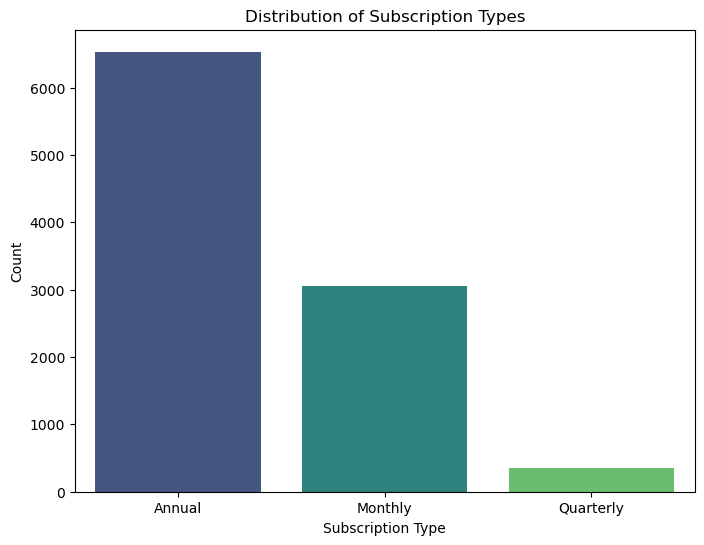

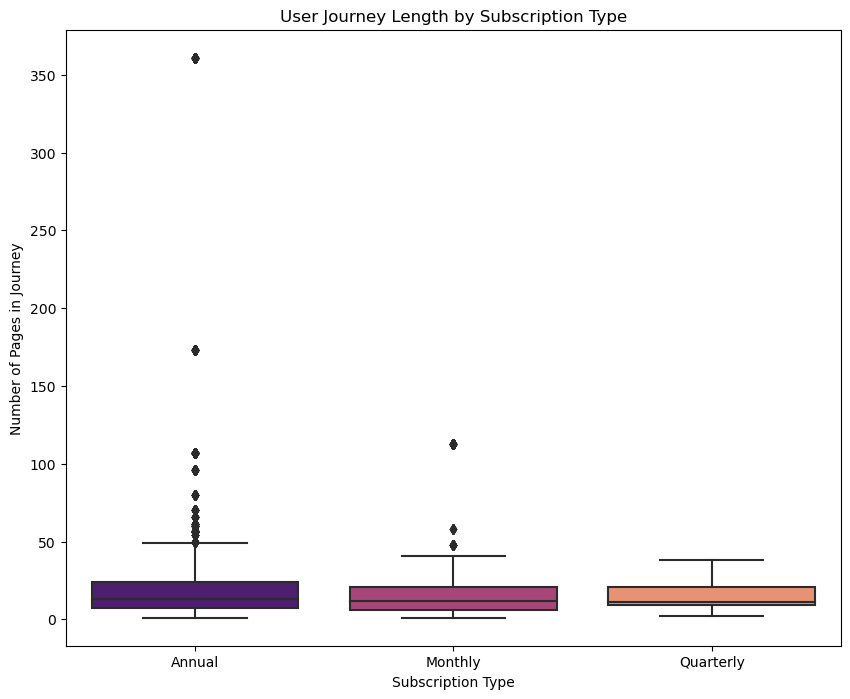

In [461]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of subscription types
plt.figure(figsize=(8, 6))
sns.countplot(x='subscription_type', data=merged_df, palette='viridis')
plt.title('Distribution of Subscription Types')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.show()

# Visualizing user journeys per subscription type
plt.figure(figsize=(10, 8))
sns.boxplot(x='subscription_type', y=merged_df['user_journey_cleaned'].apply(lambda x: len(x.split('-'))), data=merged_df, palette='magma')
plt.title('User Journey Length by Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Number of Pages in Journey')
plt.show()


* 3rd most popular page for quarterly users

In [462]:
import pandas as pd
from collections import Counter


# Filter the DataFrame for quarterly users
quarterly_users = data[data['subscription_type'] == 'Quarterly']

# Flatten all pages from the user journeys of quarterly users
all_pages = [page for journey in quarterly_users['user_journey'] for page in journey.split('-')]

# Count the occurrences of each page
page_counts = Counter(all_pages)

# Find the 3rd most common page
most_common_pages = page_counts.most_common()
if len(most_common_pages) >= 3:
    third_most_popular_page = most_common_pages[2][0]  # Index 2 for the 3rd item
    print("3rd Most Popular Page:", third_most_popular_page)
else:
    print("Less than 3 pages found for quarterly users.")


3rd Most Popular Page: Sign up


## Session Aggregation

 It's important to determine whether early sessions are more indicative of a user's intent. Consider comparing user behavior in the first few sessions versus their entire journey. For example, the first 3-5 sessions might reveal exploratory behavior, while later sessions might be more conversion-focused.

In [425]:
def analyze_first_sessions(data, n=3, target_column='user_journey'):
    """
    Analyze the first n sessions of the user journey.
    """
    data[f'first_{n}_sessions'] = data[target_column].apply(lambda x: '-'.join(x.split('-')[:n]))
    return data

In [426]:
# Example of analyzing the first 3 sessions
first_sessions_analysis = analyze_first_sessions(merged_df, n=3, target_column="user_journey_cleaned")

first_sessions_analysis[['user_id', 'first_' + str(3) + '_sessions']]

,user_id,first_3_sessions
0,1516,Homepage-Other-Other
1,1516,Homepage-Other-Other
2,1516,Homepage-Other-Other
3,1516,Homepage-Other-Other
4,1516,Homepage-Other-Other
...,...,...
9930,509095,Other-Other-Other
9931,509095,Other-Other-Other
9932,509095,Other-Other-Other
9933,509095,Other-Other-Other


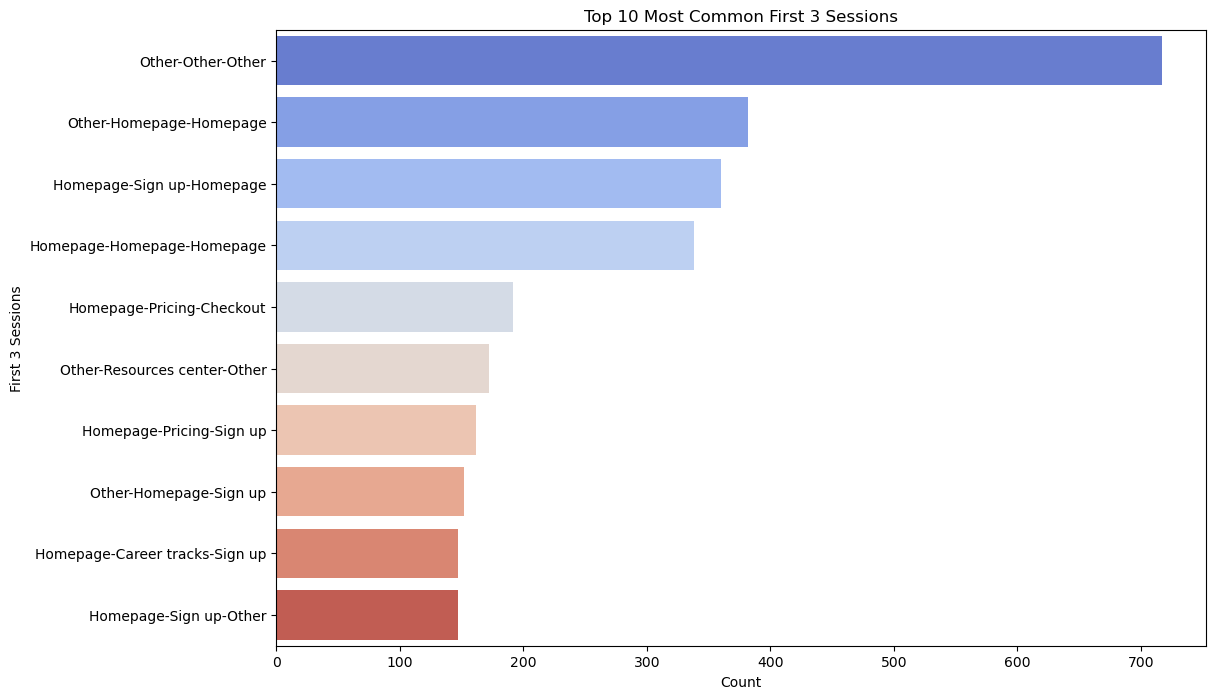

In [427]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts for each unique value in 'first_3_sessions'
top_10_sessions = first_sessions_analysis['first_3_sessions'].value_counts().nlargest(10).index

# Filter the dataframe to include only the top 10 sessions
filtered_data = first_sessions_analysis[first_sessions_analysis['first_3_sessions'].isin(top_10_sessions)]

# Plotting the top 10 most common first 3 sessions
plt.figure(figsize=(12, 8))
sns.countplot(y='first_3_sessions', data=filtered_data, order=filtered_data['first_3_sessions'].value_counts().index, palette='coolwarm')
plt.title('Top 10 Most Common First 3 Sessions')
plt.xlabel('Count')
plt.ylabel('First 3 Sessions')
plt.show()



In [428]:
def analyze_last_sessions(data, n=3, target_column='user_journey'):
    """
    Analyze the last n sessions of the user journey.
    """
    data[f'last_{n}_sessions'] = data[target_column].apply(lambda x: '-'.join(x.split('-')[-n:]))
    return data

In [429]:
# Example of analyzing the last 3 sessions
last_sessions_analysis = analyze_last_sessions(merged_df, n=3, target_column="user_journey_cleaned")

last_sessions_analysis[['user_id', 'last_' + str(3) + '_sessions']]

,user_id,last_3_sessions
0,1516,Checkout-Checkout-Checkout
1,1516,Checkout-Checkout-Checkout
2,1516,Checkout-Checkout-Checkout
3,1516,Checkout-Checkout-Checkout
4,1516,Checkout-Checkout-Checkout
...,...,...
9930,509095,Other-Other-Other
9931,509095,Other-Other-Other
9932,509095,Other-Other-Other
9933,509095,Other-Other-Other


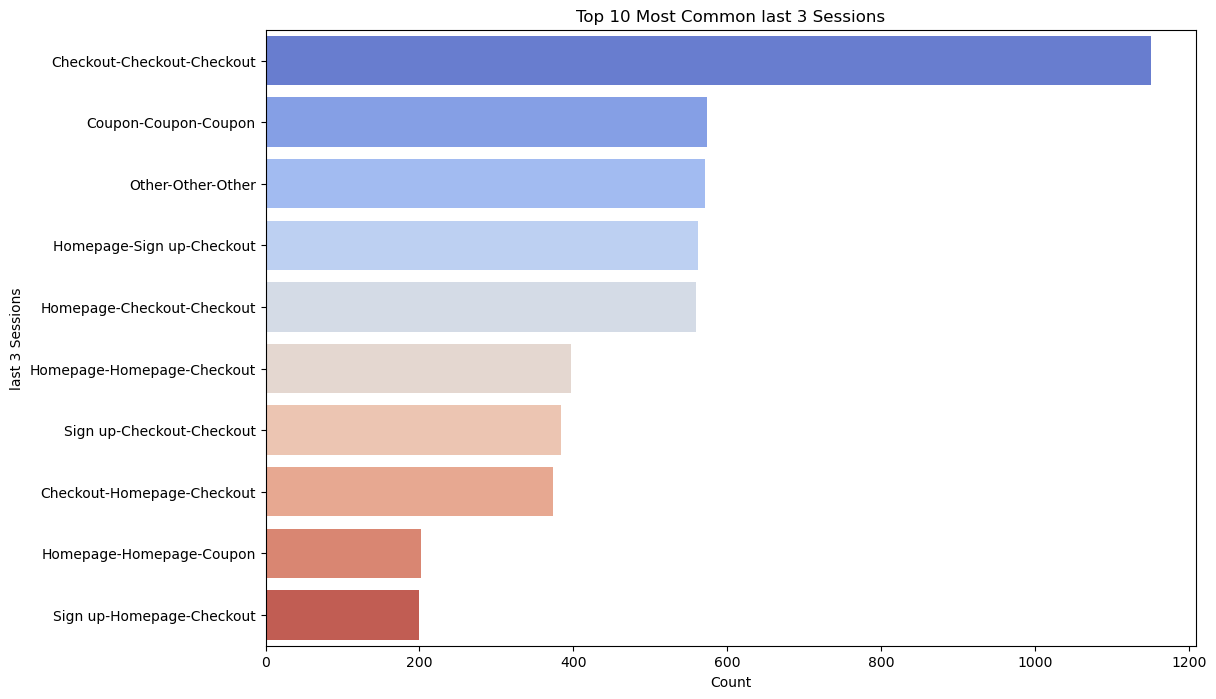

In [430]:
# Calculate the counts for each unique value in 'last_3_sessions'
top_10_sessions = last_sessions_analysis['last_3_sessions'].value_counts().nlargest(10).index

# Filter the dataframe to include only the top 10 sessions
filtered_data = last_sessions_analysis[last_sessions_analysis['last_3_sessions'].isin(top_10_sessions)]

# Plotting the top 10 most common last 3 sessions
plt.figure(figsize=(12, 8))
sns.countplot(y='last_3_sessions', data=filtered_data, order=filtered_data['last_3_sessions'].value_counts().index, palette='coolwarm')
plt.title('Top 10 Most Common last 3 Sessions')
plt.xlabel('Count')
plt.ylabel('last 3 Sessions')
plt.show()

* Average length of a user journey if you consider just the last three sessions

In [431]:
# Function to extract the last n sessions/pages
def extract_last_n_sessions(journey, n=3):
    pages = journey.split('-')
    return pages[-n:]

# Apply the function to get the last 3 sessions/pages for each user
data['last_3_sessions'] = data['user_journey'].apply(lambda x: extract_last_n_sessions(x, n=3))

# Compute the length of these last 3 sessions/pages
data['last_3_sessions_length'] = data['last_3_sessions'].apply(len)

# Calculate the average length of the last 3 sessions/pages
average_length_last_3 = data['last_3_sessions_length'].mean()

print("Average Length of Last 3 Sessions:", average_length_last_3)

Average Length of Last 3 Sessions: 2.6821338701560142


* Top 10 highest presence in the last three sessions of journeys

In [432]:
# Create a list of unique pages in the last 3 sessions for each user
data['unique_last_3_pages'] = data['last_3_sessions'].apply(lambda x: list(set(x)))

# Flatten the list of unique pages across all users to count their presence
all_unique_pages = [page for sublist in data['unique_last_3_pages'] for page in sublist]

# Count the presence of each unique page
page_presence = pd.Series(all_unique_pages).value_counts()

# # Get the page with the 4th highest presence
# fourth_highest_presence_page = page_presence.index[3]  # 3 because it's 0-indexed

# print("Page with the 4th highest presence:", fourth_highest_presence_page)

page_presence


Log in                      3711
Checkout                    1967
Other                       1255
Coupon                      1031
Sign up                      941
Courses                      485
Homepage                     400
Pricing                      397
Career tracks                321
Resources center             193
Career track certificate     113
Course certificate            54
Success stories               25
Upcoming courses              18
About us                      11
Blog                          10
Instructors                    6
Name: count, dtype: int64

## Behavioral Funnel Analysis

Construct funnels to visualize the steps leading to a purchase. This can reveal drop-off points where users are most likely to abandon the process, helping you identify areas for improvement.

In [433]:
from collections import Counter

def funnel_analysis(data, steps, target_column='user_journey'):
    funnel = {step: 0 for step in steps}
    
    for journey in data[target_column]:
        pages = journey.split('-')
        for step in steps:
            if step in pages:
                funnel[step] += 1
                
    return funnel

In [434]:
# Define steps in the funnel
funnel_steps = ['Homepage', 'Pricing', 'Sign up', 'Dashboard']

# Conduct funnel analysis
funnel_results = funnel_analysis(merged_df, funnel_steps, target_column='user_journey_cleaned')

In [435]:
funnel_results

{'Homepage': 7925, 'Pricing': 4585, 'Sign up': 6582, 'Dashboard': 0}

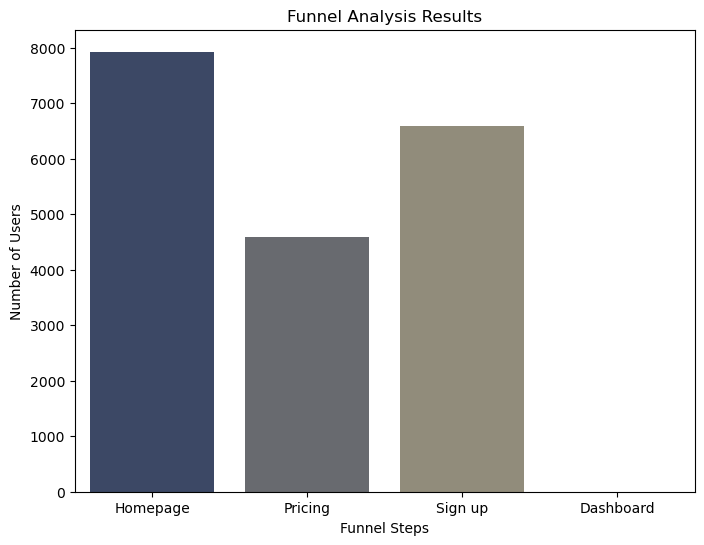

In [436]:
# Assuming funnel_results has been calculated
funnel_steps = list(funnel_results.keys())
funnel_values = list(funnel_results.values())

plt.figure(figsize=(8, 6))
sns.barplot(x=funnel_steps, y=funnel_values, palette='cividis')
plt.title('Funnel Analysis Results')
plt.xlabel('Funnel Steps')
plt.ylabel('Number of Users')
plt.show()

## 4th most popular page after the user has been on Pricing

In [465]:
import pandas as pd
from collections import Counter


# Function to find pages following "Pricing"
def find_follow_up_pages(journey, target_page='Pricing'):
    pages = journey.split('-')
    follow_up_pages = []
    for i in range(len(pages) - 1):
        if pages[i] == target_page:
            follow_up_pages.append(pages[i + 1])
    return follow_up_pages

# Extract follow-up pages after "Pricing"
all_follow_up_pages = [page for journey in data['user_journey'] for page in find_follow_up_pages(journey)]

# Count occurrences of each follow-up page
follow_up_page_counts = Counter(all_follow_up_pages)

# Find the 4th most common follow-up page
most_common_follow_up_pages = follow_up_page_counts.most_common()
if len(most_common_follow_up_pages) >= 4:
    fourth_most_popular_page = most_common_follow_up_pages[3][0]  # Index 3 for the 4th item
    print("4th Most Popular Page After Pricing:", fourth_most_popular_page)
else:
    print("Less than 4 different pages found following Pricing.")


4th Most Popular Page After Pricing: Courses


## What is the average length of a user journey if you consider just the last three sessions

In [467]:
# Function to extract the last n sessions/pages
def extract_last_n_sessions(journey, n=3):
    pages = journey.split('-')
    return pages[-n:]

# Apply the function to get the last 3 sessions/pages for each user
data['last_3_sessions'] = data['user_journey'].apply(lambda x: extract_last_n_sessions(x, n=3))

# Compute the length of these last 3 sessions/pages
data['last_3_sessions_length'] = data['last_3_sessions'].apply(len)

# Calculate the average length of the last 3 sessions/pages
average_length_last_3 = data['last_3_sessions_length'].mean()

print("Average Length of Last 3 Sessions:", average_length_last_3)


Average Length of Last 3 Sessions: 2.6821338701560142


## What is the page with the 4th highest presence in the last three sessions of journeys (not the absolute number of page visits)?

In [468]:
import pandas as pd
from collections import Counter

# Function to extract the last n sessions/pages
def extract_last_n_sessions(journey, n=3):
    pages = journey.split('-')
    return pages[-n:]

# Apply the function to get the last 3 sessions/pages for each user
df['last_3_sessions'] = df['user_journey'].apply(lambda x: extract_last_n_sessions(x, n=3))

# Create a list of all unique pages in the last 3 sessions for each user
unique_pages_per_journey = df['last_3_sessions'].apply(lambda x: set(x))

# Flatten the list of unique pages across all journeys
all_unique_pages = [page for pages in unique_pages_per_journey for page in pages]

# Count the presence of each page across unique journeys
page_presence_counts = Counter(all_unique_pages)

# Find the page with the 4th highest presence
most_common_pages = page_presence_counts.most_common()
if len(most_common_pages) >= 4:
    fourth_highest_presence_page = most_common_pages[3][0]  # Index 3 for the 4th item
    print("Page with the 4th Highest Presence:", fourth_highest_presence_page)
else:
    print("Less than 4 unique pages found in the last three sessions.")


Page with the 4th Highest Presence: Sign up
